# 03 pycox

*pycox is a libary for Survival Models based on Neural Nets - Mainly implements loss functions that can be put on top of any pytorch architecture*

* * *

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from lifelines.datasets import load_dd

import torchtuples as tt
from pycox.models import LogisticHazard, DeepHitSingle

from src.dd_column_cfg import id_col, drop_cols, cat_cols, num_cols, duration_col, event_col, target_cols

# Data

[Democracy and Dictatorship dataset](https://lifelines.readthedocs.io/en/latest/lifelines.datasets.html#lifelines.datasets.load_dd)

Classification of political regimes as democracy and dictatorship which covers 202 countries from 1946 or year of independence to 2008

In [3]:
data = load_dd()

data = data.reset_index().rename(columns={'index': id_col})
data.democracy = np.where(data.democracy=='Democracy', 1,0)

data.shape

(1808, 13)

In [4]:
data[cat_cols] = data[cat_cols].astype('category')

bin_cols = [n for n,col in data[cat_cols].items() if len(col.cat.categories) <= 2]
cat_cols = list(set(cat_cols) - set(bin_cols))

features = cat_cols + bin_cols + num_cols
col_order = num_cols + cat_cols + bin_cols + target_cols

## Train/Test Split

In [5]:
data_train, data_test = train_test_split(data, test_size=0.2)

data_train.shape, data_test.shape

((1446, 13), (362, 13))

## Transformer

In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', StandardScaler())
])

categorical_transformer_cox = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=None, strategy='constant', fill_value='Unbekannt')),
    ('ordered_cat', OrdinalEncoder())
])

transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer_cox, cat_cols),
        ('passthrough', 'passthrough', bin_cols + target_cols),
        ('drop', 'drop', drop_cols + [id_col])
    ])

In [7]:
train = transformer.fit_transform(data_train, data_train[duration_col])
test = transformer.transform(data_test)

In [8]:
train = pd.DataFrame(train, columns=col_order)
test = pd.DataFrame(test, columns=col_order)

# Model

In [9]:
num_nodes = [64, 64, 64]
batch_norm = True
dropout = 0.1
dropout_embedding = 0.1
batch_size = 256

In [10]:
x_train_cox = transformer.fit_transform(data_train)
x_train_cox_df = pd.DataFrame(x_train_cox, columns=col_order)
x_train_cox_df[cat_cols] = x_train_cox_df[cat_cols].astype('category')

x_test_cox = transformer.transform(data_test)
x_test_cox_df = pd.DataFrame(x_test_cox, columns=col_order)
x_test_cox_df[cat_cols] = x_test_cox_df[cat_cols].replace({-1: 0})

In [11]:
emb_dict = {n: len(col.cat.categories) for n, col in x_train_cox_df[cat_cols].items()}
emb_sizes = [(c, min(20, (c + 1) // 2)) for _, c in emb_dict.items()]
emb_cols = emb_dict.keys()

num_embeddings = np.array([x[0] for x in emb_sizes])
embedding_dims = np.array([x[1] for x in emb_sizes])
vocab_size = np.sum(num_embeddings) + 1

embedding_dims, vocab_size

(array([11,  3,  3]), 34)

In [12]:
x_train_tup_cox = tt.tuplefy(np.array(x_train_cox_df[num_cols + bin_cols]).astype('float32'), 
                             np.array(x_train_cox_df[cat_cols]).astype('int64'))

x_test_tup_cox = tt.tuplefy(np.array(x_test_cox_df[num_cols + bin_cols]).astype('float32'), 
                        np.array(x_test_cox_df[cat_cols]).astype('int64'))

In [13]:
y_train_tup_cox = tt.tuplefy(np.array(data_train[duration_col]).astype('int64'), 
                         np.array(data_train[event_col]).astype('float32'))

y_test_tup_cox = tt.tuplefy(np.array(data_test[duration_col]).astype('int64'), 
                        np.array(data_test[event_col]).astype('float32'))

test_cox = (x_test_tup_cox, y_test_tup_cox)

In [14]:
cuts = list(range(1, data[duration_col].max()+1))
time_grid = np.array(cuts)

cuts[:3], cuts[-3:]

([1, 2, 3], [45, 46, 47])

In [15]:
net = tt.practical.MixedInputMLP(in_features=len(num_cols + bin_cols), 
                         num_embeddings=num_embeddings + 1,
                         embedding_dims=embedding_dims,
                         out_features=max(cuts)+1,
                         num_nodes=num_nodes, 
                         batch_norm=batch_norm, 
                         dropout=dropout, 
                         dropout_embedding=dropout_embedding)

model = LogisticHazard(net=net, optimizer=tt.optim.Adam(lr=0.01, weight_decay=0))
history = model.fit(input=x_train_tup_cox, target=y_train_tup_cox, batch_size=batch_size, 
                    epochs=5, val_data=test_cox, verbose=True)

0:	[0s / 0s],		train_loss: 3.8764,	val_loss: 3.5575
1:	[0s / 0s],		train_loss: 3.1203,	val_loss: 2.8848
2:	[0s / 0s],		train_loss: 2.6489,	val_loss: 2.3406
3:	[0s / 0s],		train_loss: 2.2231,	val_loss: 2.0265
4:	[0s / 0s],		train_loss: 2.0131,	val_loss: 1.9534


In [16]:
y_pred_surv = model.predict_surv_df(x_test_tup_cox).round(3)

# Visualize Output

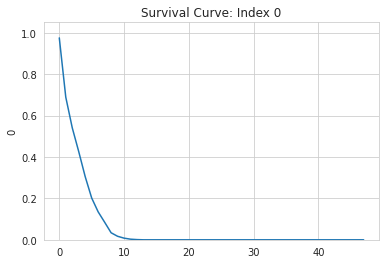

In [17]:
idx=0

sns.lineplot(data=y_pred_surv[idx])
plt.title(f'Survival Curve: Index {idx}')
plt.ylim(0,1.05);

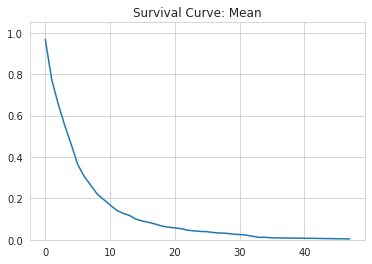

In [18]:
sns.lineplot(data=y_pred_surv.mean(axis=1))
plt.title('Survival Curve: Mean')
plt.ylim(0,1.05);